# Assignment 2:

In this assignment, you are going to solve three problems: 

1. Improving Nearest Neighbors Retrieval Speed (8 points)
2. Gaussian Naive Bayes (4 points)
3. PCA (3 points)

## 1. Improving Nearest Neighbors Retrieval Speed (8 points)

You are given a dataset of coordinates and information about places around the globe. Explore the dataset. You will be mostly working with 2d vectors which represent longitude and latitude.

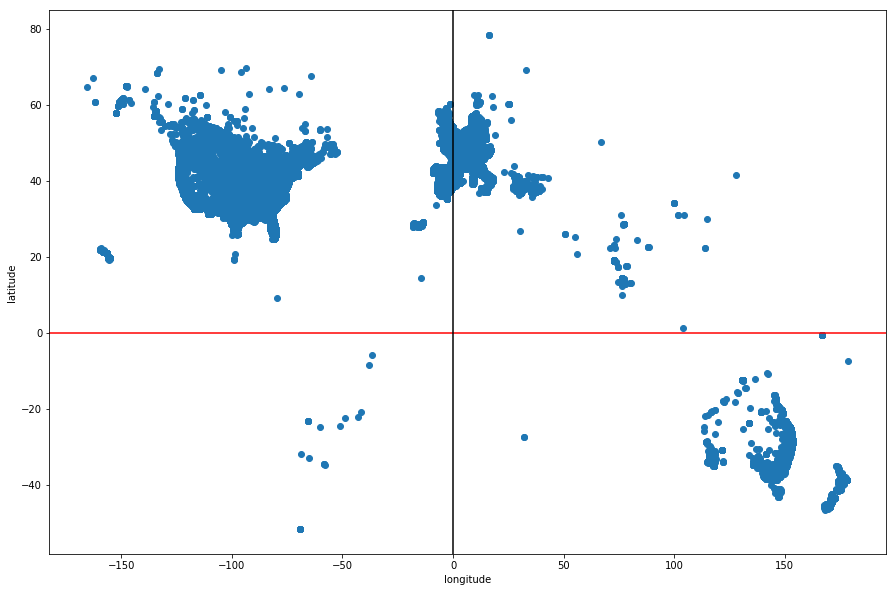

In [2]:
import pickle
import matplotlib.pyplot as plt

with open("poi_sample001.pickle", "rb") as f:
    dataset = pickle.load(f)
    
X = [v[0][0] for v in dataset]
Y = [v[0][1] for v in dataset]

plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.show()

### 1.1 Simple NN Search

Implement the simplest form of NN search (exhaustive search).
Your function should: 
1. Calculate the distance between the test point and each dataset point using euclidean distance.
2. Sort the dataset according to calculated distance in ascending order.
3. Return the top K points from the sorted dataset.

You need to implement this from scratch. Don't use library solutions. 
It is okay to use library function for eucliden distance.

In [25]:
from numpy.linalg import norm
import numpy as np

In [26]:
def simple_nns(v, data, k):
    """
    param: v: test point
    param: data: dataset
    param: k: number of nearest neighbors to retrive
    return: list of nearest points from the dataset
    """
    # implement simple NN Search
    v = np.asarray(v)
    data = np.asarray(data)
    dists = []
    
    for d in data:
        dists.append(norm(d-v))
        
    dists = np.asarray(dists)
    idxs = np.argsort(dists)[:k]    
    
    return list(data[idxs])

Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

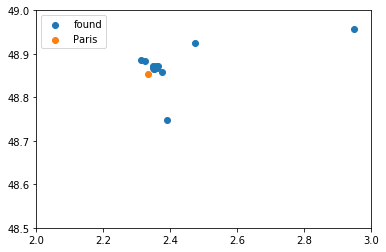

In [27]:
paris = [2.334083, 48.853260]

shops_coords = []
for i in dataset:
    if 'shop' in i[1].lower():
        shops_coords.append(i[0])


# find and plot the nearest neighbors according to the above instructions
paris_nn = simple_nns(v=paris, data=shops_coords, k=100)

Xs = [v[0] for v in paris_nn]
Ys = [v[1] for v in paris_nn]

# axes limits are set for better visualization, don't change them
plt.scatter(Xs, Ys, label ='found')
plt.scatter(paris[0], paris[1], label='Paris')
plt.legend()

plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.show()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

In [28]:
from time import time

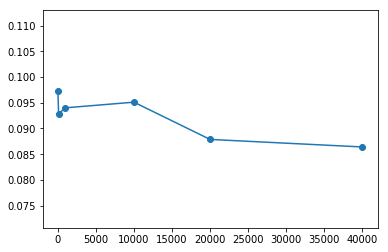

In [65]:
# numbers of nearest neghbors to retrieve
nns = [10, 100, 1000, 10000, 20000, 40000]

nns_res = []

# measure retrival time for every value above and save it somewhere

# this one is called to avoid cache influence
simple_nns(v=paris, data=shops_coords, k=5)

for n in nns:
    start_time = time()
    simple_nns(v=paris, data=shops_coords, k=n)
    end_time = time()
    nns_res.append(end_time - start_time)

# plot the results
plt.scatter(nns, nns_res)
plt.plot(nns, nns_res)

What do you observe? Do you see any trends, how can you explain them?

<span style="color:blue"> Your answer: </span> You can try to rerun the upper cell several times and you will get a bit different plots (and even trends), but what is more important the difference between max and min values will be rather small, which means that for exact search there is no trend, the time is more or less constant and the differences in time may be explained with other applications running on the PC

### 1.2 Improving NNS

Choose any method you like to speed up NN search, understand it thoroughly and learn how to apply it. Explain the way it works in few sentences and in your own words.

<span style="color:blue"> Your answer: </span> I have chosen Annoy. The idea is that we have a fixed number N and dataset points, we randomly pick 2 points and make a hyperplane that is equidistant from those 2 points. Hence, now we have 2 groups of points (one and the other side of the hyperplane), then we repeat this process recursively in each group, we do it while the number of points in the group is more than N. At the end we have all initial points belonging to some group, for a test point we find to which group it belongs and take k nearest elements from this group or check subsequent groups if needed.

Apply the chosen method on the geographic dataset. Similarly to the above, find the nearest neighbors and plot retrieval times.

Inspired by:
* https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6
* https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html
* https://github.com/spotify/annoy

In [30]:
# !pip install --user annoy

In [31]:
# apply the chosen method
from annoy import AnnoyIndex
import random

t = AnnoyIndex(len(shops_coords[0]), 'angular')  # Length of item vector that will be indexed
for i, v in enumerate(shops_coords):
    t.add_item(i, v)
    
t.build(10) # 10 trees

True

Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

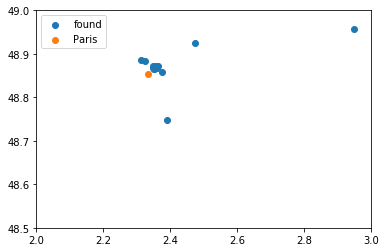

In [32]:
paris = [2.334083, 48.853260]

# find and plot the nearest neighbors according to the above instructions
# t.add(i, len(shops_coords))

indx = t.get_nns_by_vector(paris, 100) # will find the 100 nearest neighbors
paris_nn = [shops_coords[i] for i in indx]

Xs_apr = [i[0] for i in paris_nn]
Ys_apr = [i[1] for i in paris_nn]

# axes limits are set for better visualization, don't change them
plt.scatter(Xs_apr, Ys_apr, label ='found')
plt.scatter(paris[0], paris[1], label='Paris')
plt.legend()


# axes limits are set for better visualization, don't change them
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.show()

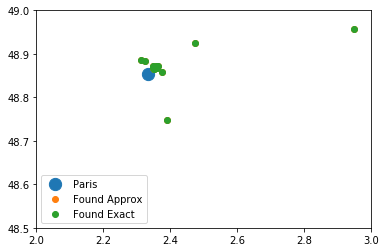

In [54]:
# compare all predictions
# at least for the most close elements they are the same
plt.scatter(paris[0], paris[1], label='Paris', s=150)
plt.scatter(Xs_apr, Ys_apr, label ='Found Approx')
plt.scatter(Xs, Ys, label ='Found Exact')
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.legend()

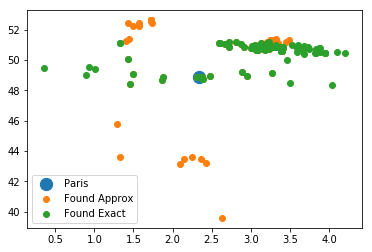

In [55]:
# but on average exact search is obviously working better
plt.scatter(paris[0], paris[1], label='Paris', s=150)
plt.scatter(Xs_apr, Ys_apr, label ='Found Approx')
plt.scatter(Xs, Ys, label ='Found Exact')
plt.legend()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

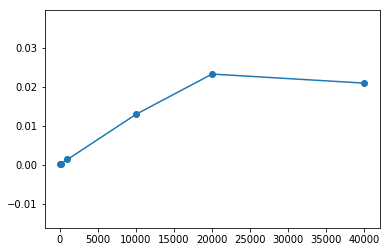

In [62]:
# numbers of nearest neghbors to retrieve
nns = [10, 100, 1000, 10000, 20000, 40000]

# measure retrival time for every value above and save it somewhere 
nns_res_appr =[]

for n in nns:
    start_time = time()
    t.get_nns_by_vector(paris, n)
    end_time = time()
    nns_res_appr.append(end_time - start_time)

# plot the results
plt.scatter(nns, nns_res_appr)
plt.plot(nns, nns_res_appr)

In [63]:
print(len(shops_coords))

17807


What do you observe? Do you see any trends, how can you explain them?

<span style="color:blue"> Your answer: </span> Time increases with increasing the number of neigbors we want to find. However, the total length of our dataset is 17807, which is less than 20 000 and 40 000, hence, there is no grows after 20000 neigbors

### 1.3 Comparison

Plot retrieval times together in the same plot. If time difference is big (as it should be), use a logarithmic scale for better visualization. If you don't achieve any time improvements, then you are doing something wrong.

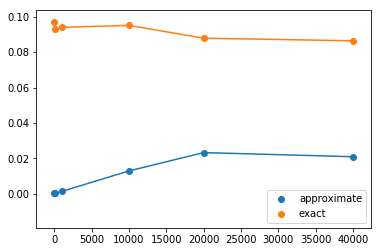

In [67]:
# plot retrieval times together

plt.scatter(nns, nns_res_appr, label = 'approximate')
plt.plot(nns, nns_res_appr)
plt.scatter(nns, nns_res, label= 'exact')
plt.plot(nns, nns_res)
plt.legend()

Analyze the results and summarise them here. 

<span style="color:blue"> Your answer: </span> The exact search time seems to be more or less constant, while the approximate knn time grows with increasing the number of neigbors and goes to its upper bound, when number of neigbors is equal to the number of elements in the dataset. Anyway, even for such cases time for improved knn is approximately 5 time less than time needed for exact knn search (~0.02 VS ~0.1) 

## 2. Gaussian Naive Bayes (4 points)

Finish the implementation of Gaussian NB.

Inspered by
* https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
* https://towardsdatascience.com/implementing-naive-bayes-in-2-minutes-with-python-3ecd788803fe
* https://towardsdatascience.com/how-to-impliment-a-gaussian-naive-bayes-classifier-in-python-from-scratch-11e0b80faf5a

In [95]:
from scipy.stats import norm

In [101]:
class GaussianNB:
    def fit(self, X_train, y_train):
        """
        fit classifier, i.e. calculate needed statistics
        """
        ### START CODE HERE ###
        
        means = {}
        std = {}
        prior = {}
        for i in list(set(y_train)):
            rows = np.argwhere(y_train==i)
            prior[i] = len(rows)/len(y_test)
            means[i] = X_train[rows].mean(axis=0)[0]
            std[i] = X_train[rows].std(axis=0)[0]
            
        
        self.prior = prior
        self.means = means
        self.std = std
        
        ### END CODE HERE ###
        
    def predict(self, X_test):
        """
        predict class labels for test data points
        param: test_data: list of data points to be classified
        return: predictions (class labels)
        """
        ### START CODE HERE ###
        # predict probabilities
        default_probs = {}

        for i in self.prior.keys():
            default_probs[i] = np.log(self.prior[i])
        
        predictions = []
        for x in X_test:
            cur_probs = {}
            for i in self.prior.keys():
                cur_probs[i] = default_probs[i]
                for j in range(len(self.means[i])):
                    cur_probs[i]*= norm.pdf(x[j], self.means[i][j], self.std[i][j])
            # choose the label with maximum probability for this item            
            lst = list(cur_probs.keys())
            fin_probs = np.argmax(np.asarray([cur_probs[c] for c in lst]))
            predictions.append(lst[fin_probs]) 
                
                
        ### END CODE HERE ###
        
        return predictions

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=0)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)


# You should get the accuracy score not less than 90%.
print(accuracy_score(y_test, y_pred))

1.0


## 3. PCA

Apply PCA to the Digits dataset, produce the scree plot for the given data and decide the optimal number of PCs to keep. Calculate and print their total explained variance.

Inspired by:
* https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
* https://districtdatalabs.silvrback.com/principal-component-analysis-with-python

Explained Variance for 40 components [0.14890594 0.13618771 0.11794594 0.08409979 0.05782415 0.0491691
 0.04315987 0.03661373 0.03353248 0.03078806 0.02372341 0.02272697
 0.01821863 0.01773855 0.01467101 0.01409716 0.01318589 0.01248138
 0.01017718 0.00905617 0.00889538 0.00797123 0.00767493 0.00722904
 0.00695889 0.00596081 0.00575615 0.00515158 0.0048954  0.00428888
 0.00373606 0.00353274 0.00336684 0.0032803  0.00308321 0.00293779
 0.00256589 0.00227742 0.00222278 0.0021143 ]


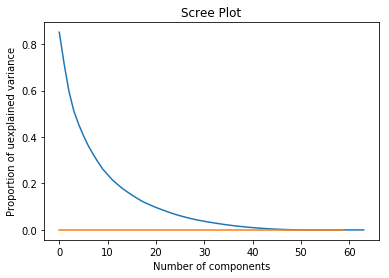

In [68]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
X, y = load_digits(return_X_y=True)

# apply PCA
pca = PCA()
pca.fit_transform(X)


# make scree plot
plt.plot(1-np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Proportion of uexplained variance')
plt.title("Scree Plot")
plt.plot([0]*60)

# choose the number PCs and calculate and print their total explained variance
n = np.argwhere(np.cumsum(pca.explained_variance_ratio_)>=0.99)[0][0]
pca = PCA(n_components = n)
pca.fit_transform(X)
print(f'Explained Variance for {n} components {pca.explained_variance_ratio_}')

Thoroughly justify your choice - this is the main part of the work for this task.

<span style="color:blue"> Your answer: </span>  There is always a trade-off between the number of components to take (the more is the number of components, the more space we need and the more time will be needed for the following computations) and the proportion of explained variance. First components explain the majority of variance, for instance, in our case first 15 components explained more than 80% of variance, however, even 20% information loss maybe crucial for further applications (for instance, if our principar components a input for a DNN). Usually, the percentage of explain variance needed is limited by signal to noise ratio, or, how much of our variance is explained by systematic noise (not outliers), as there is no sense to take PC that expain noise (hence, we take components that explain at most (1-variance is explained by systematic noise) proportion of variance). Here, as we do not put those compenets anywheeree further and there is no infp abput noise in the dataset, I've just taken the PC that explains ~99% of variance (additional percent would cost about 10 more PC).